<a href="https://colab.research.google.com/github/IlyessAgg/mLproject/blob/main/Deep_Learning_with_PyTorch_GradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GradCAM - Gradient Class Activation Map

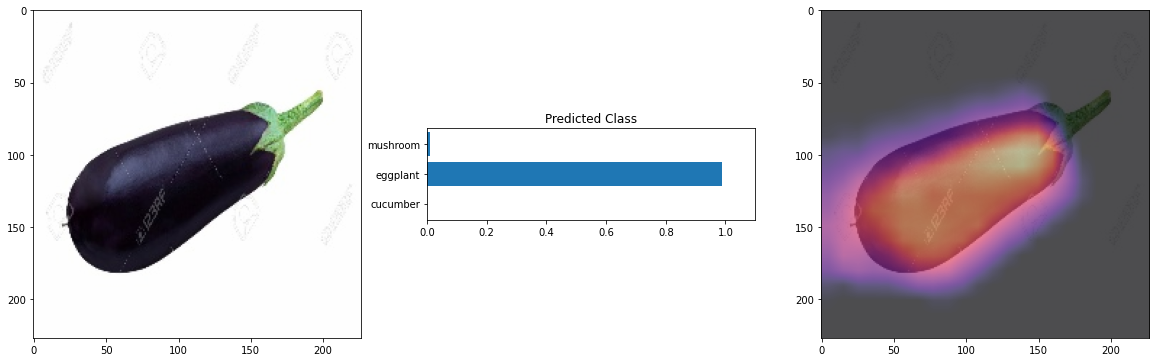

In [ ]:
!git clone https://github.com/parth1620/GradCAM-Dataset.git
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Cloning into 'GradCAM-Dataset'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 193 (delta 0), reused 193 (delta 0), pack-reused 0
Receiving objects: 100% (193/193), 2.59 MiB | 17.20 MiB/s, done.
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-9aaut2iy
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-9aaut2iy
  Resolved https://github.com/albumentations-team/albumentations to commit c87c214e0e3b15d1ca278a5a378b0c9ebd4619f1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.5/

# Imports

In [ ]:
import sys
sys.path.append('/content/GradCAM-Dataset')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms as T

from tqdm import tqdm
import albumentations as A
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import utils

# Configurations

In [ ]:
CSV_FILE = "/content/GradCAM-Dataset/train.csv"
DATA_DIR = "/content/GradCAM-Dataset/"

DEVICE = 'cuda'

BATCH_SIZE = 16
LR = 0.001
EPOCHS = 20

In [ ]:
data = pd.read_csv(CSV_FILE)
data.head()

,img_path,label
0,train_images/mushroom_51.jpg,2
1,train_images/eggplant_37.jpg,1
2,train_images/mushroom_20.jpg,2
3,train_images/eggplant_51.jpg,1
4,train_images/eggplant_26.jpg,1


In [ ]:
# Cucumber = 0, Eggplant = 1, Mushroom = 2
train_df, valid_df = train_test_split(data, test_size = 0.2, random_state=42)

# Augmentations

In [ ]:
train_augs = A.Compose([
    A.HorizontalFlip(p = 0.5),
    A.VerticalFlip(p = 0.5),
    A.Rotate(),
    A.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])
valid_augs = A.Compose([
    A.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

# Load Image Dataset

In [ ]:
trainset = utils.ImageDataset(train_df, augs = train_augs, data_dir=DATA_DIR)
validset = utils.ImageDataset(valid_df, augs = valid_augs, data_dir=DATA_DIR)

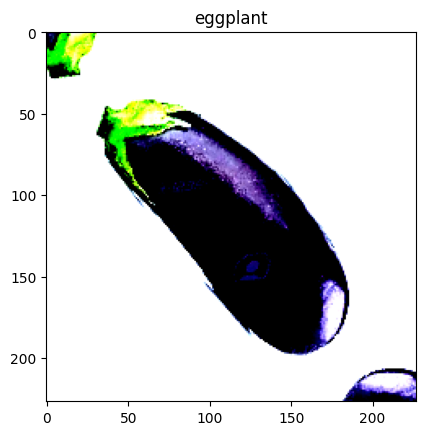

In [ ]:
image, label = trainset[0]

class_list = ['cucumber', 'eggplant', 'mushroom']

plt.imshow(image.permute(1, 2, 0))
plt.title(class_list[label]);

In [ ]:
print(f"No. of examples in the trainset {len(trainset)}")
print(f"No. of examples in the validset {len(validset)}")

No. of examples in the trainset 148
No. of examples in the validset 38


# Load Dataset into Batches

In [ ]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE, shuffle=False)

In [ ]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 10
No. of batches in validloader : 3


In [ ]:
for images, labels in trainloader:
  break;

print(f"One batch image shape : {images.shape}")
print(f"One batch label shape : {labels.shape}")

One batch image shape : torch.Size([16, 3, 227, 227])
One batch label shape : torch.Size([16])


# Create Model

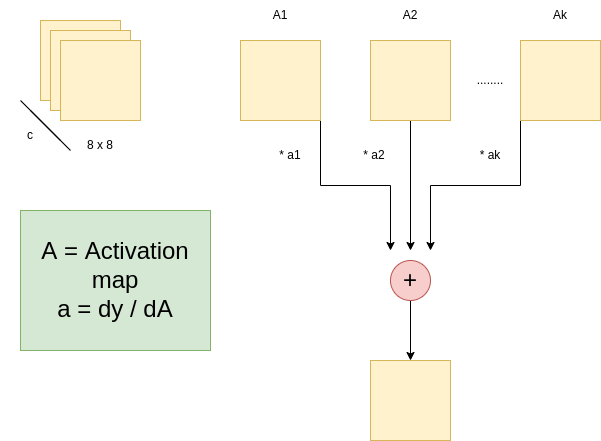

In [ ]:
class ImageModel(nn.Module):

  def __init__(self):
    super(ImageModel, self).__init__()

    self.feature_extractor = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(5,5), padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(4,4), stride=2),

        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(5,5), padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(4,4), stride=2),

        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5,5), padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(4,4), stride=2),

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), padding=1),
        nn.ReLU(),
    )

    self.maxpool = nn.MaxPool2d(kernel_size=(4,4), stride=2)

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(6400, 2048),
        nn.ReLU(),
        nn.Linear(2048, 3)
    )

    self.gradient = None

  def activations_hook(self, grad):
    self.gradient = grad

  def forward(self, images):

    x = self.feature_extractor(images)
    h = x.register_hook(self.activations_hook)
    x = self.maxpool(x)
    x = self.classifier(x)

    return x

  def get_activation_gradients(self): #a1...ak
    return self.gradient

  def get_activation(self, x): #A1....Ak
    return self.feature_extractor(x)

In [ ]:
model = ImageModel()
model.to(DEVICE)

ImageModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6400, out_features=2048, bias=True)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=3, bias=True)
  )
)

# Create Train and Eval function

In [ ]:
def train_fn(dataloader, model, optimizer, criterion):

  model.train()
  total_loss = 0.0
  for images, labels in tqdm(dataloader):

    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    optimizer.zero_grad()
    logits = model(images)
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [ ]:
def eval_fn(dataloader, model, criterion):

  model.eval()
  total_loss = 0.0
  for images, labels in tqdm(dataloader):

    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    logits = model(images)
    loss = criterion(logits, labels)

    total_loss += loss.item()

  return total_loss / len(dataloader)

# Training Loop

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(trainloader, model, optimizer, criterion)
  valid_loss = eval_fn(validloader, model, criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_weights.pt')
    best_valid_loss = valid_loss
    print("SAVED-WEIGHTS-SUCCESS")

  print(f"EPOCH : {i+1} TRAIN LOSS : {train_loss} VALID LOSS : {valid_loss}")

100%|██████████| 3/3 [00:00<00:00, 43.28it/s]


SAVED-WEIGHTS-SUCCESS
EPOCH : 1 TRAIN LOSS : 1.0094436645507812 VALID LOSS : 0.7152976791063944


100%|██████████| 3/3 [00:00<00:00, 45.58it/s]


SAVED-WEIGHTS-SUCCESS
EPOCH : 2 TRAIN LOSS : 0.8102643549442291 VALID LOSS : 0.4745069940884908


100%|██████████| 3/3 [00:00<00:00, 45.21it/s]


SAVED-WEIGHTS-SUCCESS
EPOCH : 3 TRAIN LOSS : 0.36698490642011167 VALID LOSS : 0.31259308010339737


100%|██████████| 3/3 [00:00<00:00, 34.05it/s]


EPOCH : 4 TRAIN LOSS : 0.3260430105030537 VALID LOSS : 0.31488314767678577


100%|██████████| 3/3 [00:00<00:00, 36.45it/s]


EPOCH : 5 TRAIN LOSS : 0.2542022876441479 VALID LOSS : 0.40578217556079227


100%|██████████| 3/3 [00:00<00:00, 32.27it/s]


EPOCH : 6 TRAIN LOSS : 0.11937193813500926 VALID LOSS : 0.32273365805546445


100%|██████████| 3/3 [00:00<00:00, 34.27it/s]


EPOCH : 7 TRAIN LOSS : 0.12172225054819137 VALID LOSS : 0.4358692020177841


100%|██████████| 3/3 [00:00<00:00, 40.38it/s]


SAVED-WEIGHTS-SUCCESS
EPOCH : 8 TRAIN LOSS : 0.11579928867286071 VALID LOSS : 0.2795698867800335


100%|██████████| 3/3 [00:00<00:00, 43.66it/s]


SAVED-WEIGHTS-SUCCESS
EPOCH : 9 TRAIN LOSS : 0.10940947682829574 VALID LOSS : 0.27857427423199016


100%|██████████| 3/3 [00:00<00:00, 47.61it/s]


SAVED-WEIGHTS-SUCCESS
EPOCH : 10 TRAIN LOSS : 0.10847996007651091 VALID LOSS : 0.15457647185151777


100%|██████████| 3/3 [00:00<00:00, 44.77it/s]


EPOCH : 11 TRAIN LOSS : 0.04866975783370435 VALID LOSS : 0.20333808567374945


100%|██████████| 3/3 [00:00<00:00, 46.43it/s]


SAVED-WEIGHTS-SUCCESS
EPOCH : 12 TRAIN LOSS : 0.16032662807265297 VALID LOSS : 0.07743535204402481


100%|██████████| 3/3 [00:00<00:00, 47.96it/s]


EPOCH : 13 TRAIN LOSS : 0.06748544776346535 VALID LOSS : 0.16535824118182063


100%|██████████| 3/3 [00:00<00:00, 50.10it/s]


EPOCH : 14 TRAIN LOSS : 0.06378808424342423 VALID LOSS : 0.35371215680303675


100%|██████████| 3/3 [00:00<00:00, 49.29it/s]


EPOCH : 15 TRAIN LOSS : 0.19225449382793158 VALID LOSS : 0.2527037461598714


100%|██████████| 3/3 [00:00<00:00, 45.94it/s]


EPOCH : 16 TRAIN LOSS : 0.32706368453800677 VALID LOSS : 0.5934229443470637


100%|██████████| 3/3 [00:00<00:00, 49.16it/s]


EPOCH : 17 TRAIN LOSS : 0.22388571612536906 VALID LOSS : 0.39288708319266635


100%|██████████| 3/3 [00:00<00:00, 43.09it/s]


EPOCH : 18 TRAIN LOSS : 0.11401254306547344 VALID LOSS : 0.533973648523291


100%|██████████| 3/3 [00:00<00:00, 46.55it/s]


EPOCH : 19 TRAIN LOSS : 0.5839520644629375 VALID LOSS : 0.2123976262907187


100%|██████████| 3/3 [00:00<00:00, 48.83it/s]

EPOCH : 20 TRAIN LOSS : 0.16857169214636086 VALID LOSS : 0.4254258871078491


# Get GradCAM

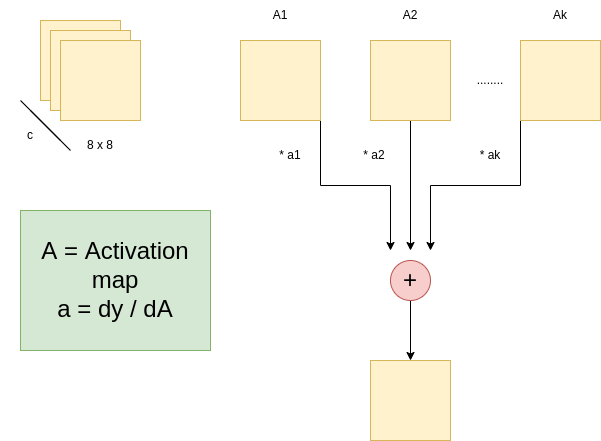

In [ ]:
def get_gradcam(model , image, label, size):

  label.backward()
  gradients = model.get_activation_gradients()
  pooled_gradients = torch.mean(gradients, dim=[0,2,3])
  activations = model.get_activation(image).detach()

  for i in range(activations.shape[1]):
    activations[:, i, :, :] *= pooled_gradients[i]

  heatmap = torch.mean(activations, dim=1).squeeze().cpu()
  heatmap = nn.ReLU()(heatmap)
  heatmap /= torch.max(heatmap)
  heatmap = cv2.resize(heatmap.numpy(), (size, size))

  return heatmap

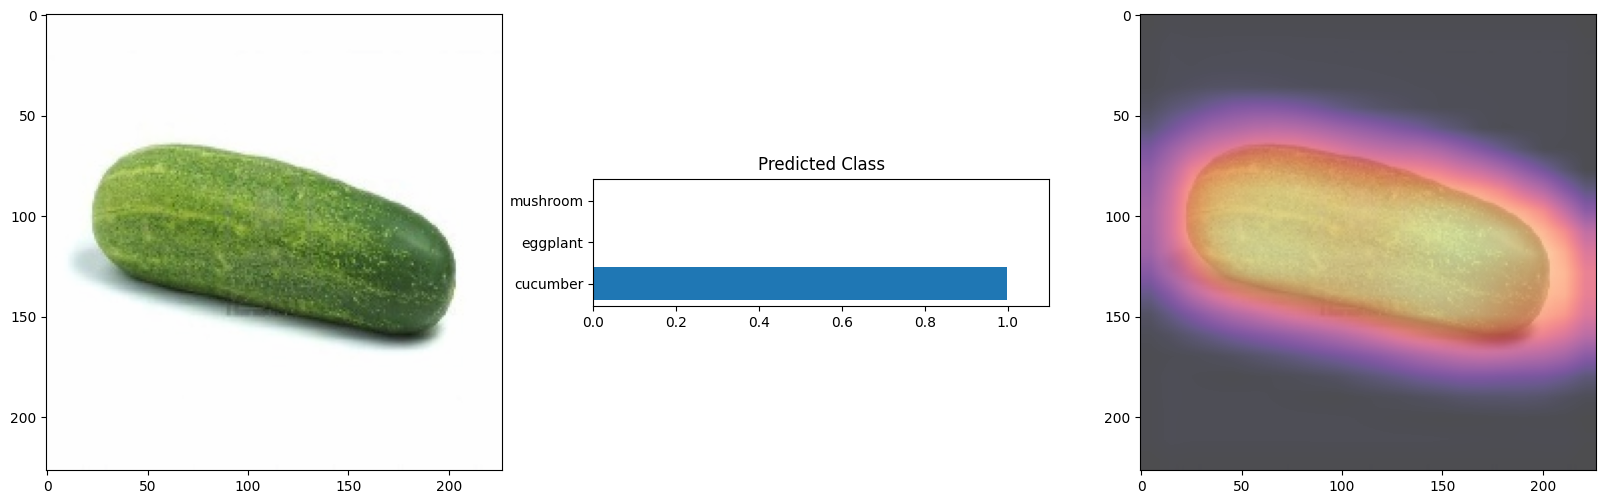

In [ ]:
image, label = validset[7]

denorm_image = image.permute(1,2,0) * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))

image = image.unsqueeze(0).to(DEVICE)

pred = model(image)
heatmap = get_gradcam(model, image, pred[0][0], size=227) #pred[0][0-1-2]
utils.plot_heatmap(denorm_image, pred, heatmap)